In [1]:
import os
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
class FoGPrediction(object):
    def __init__(self, filepath, past, future):
        self.filepath = filepath
        self.past = past
        self.savepath = '/kaggle/working/train/tdcsfog'
        self.future = future
        self.series_inputs = []
        self.series_targets = []
    
    def sample_normalize(self, sample):
        mean = tf.math.reduce_mean(sample)
        std = tf.math.reduce_std(sample)
        sample = tf.math.divide_no_nan(sample-mean, std)
        return sample.numpy()
    
    def load_sample(self, file):
        series = pd.read_csv(os.path.join(self.filepath, file))
        series['AccV'] = self.sample_normalize(series['AccV'].values)
        series['AccML'] = self.sample_normalize(series['AccML'].values)
        series['AccAP'] = self.sample_normalize(series['AccAP'].values)
        inputs = series[['AccV', 'AccML', 'AccAP']]
        targets = series[['StartHesitation', 'Turn', 'Walking']]
        # convert to numpy
        inputs = inputs.values
        inputs = inputs.astype(np.float32)
        targets = targets.values
        targets = targets.astype(np.float32)
        
        # print(f"Input shape: {inputs.shape}, Target shape: {targets.shape}")
        # load to RAM
        n = len(inputs)
        input_start = 0
        input_main = self.past
        input_end = input_main + self.future
        while input_end < n:
            self.series_inputs.append(inputs[input_start: input_end + 1])
            self.series_targets.append(targets[input_main])
            input_start += 1
            input_main += 1
            input_end += 1
    
    def plot(self, _dict):
        plt.bar(*zip(*_dict.items()))
        plt.show()
    
    def load_all(self):
        # read from file, if available
        if (os.path.exists(os.path.join(self.savepath, "series_inputs.npy"))):
            self.series_inputs = np.load(os.path.join(self.savepath, "series_inputs.npy"))
            self.series_targets = np.load(os.path.join(self.savepath, "series_targets.npy"))
        else:
            os.makedirs(self.savepath)
            tdcsfog_metadata = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/tdcsfog_metadata.csv').set_index('Id')
            val_subjects = ['07285e', '220a17', '54ee6e', '312788', '24a59d', '4bb5d0', '48fd62', '79011a', '7688c1']
            # get train and validation IDs
            train_ids = tdcsfog_metadata[tdcsfog_metadata['Subject'].apply(lambda x: x not in val_subjects)].index.tolist()
            val_ids = tdcsfog_metadata[tdcsfog_metadata['Subject'].apply(lambda x: x in val_subjects)].index.tolist()
            for id in tqdm(train_ids):
                self.load_sample(id + ".csv")
            self.series_inputs = np.asarray(self.series_inputs, dtype=np.float32)
            self.series_targets = np.asarray(self.series_targets, dtype=np.uint8)
            np.save(os.path.join(self.savepath, "series_inputs.npy"), self.series_inputs)
            np.save(os.path.join(self.savepath, "series_targets.npy"), self.series_targets)
        print(f"Inputs shape: {self.series_inputs.shape}, targets shape: {self.series_targets.shape}")
    
    def balance(self):
        start_hes = np.where(self.series_targets[:,0] == 1)[0]
        turn = np.where(self.series_targets[:,1] == 1)[0]
        walk = np.where(self.series_targets[:,2] == 1)[0]
        nothing = np.where(
            (
                (self.series_targets[:,0] == 0) &
                (self.series_targets[:,1] == 0) &
                (self.series_targets[:,2] == 0)
            )
        )[0]
        # print(f"Start Hestitation: {len(start_hes)}, Turn: {len(turn)}, Walk: {len(walk)}, Others: {len(nothing)}")
        self.plot({
            "Start Hestitation": len(start_hes), 
            "Turn": len(turn), 
            "Walk": len(walk),
            "Nothing": len(nothing)
        })
        n = min(
            len(start_hes),
            len(turn),
            len(walk),
            len(nothing)
        )
        final_indexes = self.random_sampling(start_hes, n) + \
                            self.random_sampling(turn, n) + \
                            self.random_sampling(walk, n) + \
                            self.random_sampling(nothing, n)
        self.series_inputs = np.asarray([self.series_inputs[i] for i in final_indexes], dtype=np.float32)
        # self.series_targets = np.asarray([self.series_targets[i] for i in final_indexes], dtype=np.uint)
        self.series_targets = np.array([0] * n + [1] * n + [2] * n + [3] * n)
        print(f"Inputs shape: {self.series_inputs.shape}, targets shape: {self.series_targets.shape}")
    
    def random_sampling(self, arr, n):
        return random.sample(arr.tolist(), n)

In [3]:
fog = FoGPrediction("/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog", 10, 10)
fog.load_all()

100%|██████████| 717/717 [00:34<00:00, 20.80it/s]


Inputs shape: (6058543, 21, 3), targets shape: (6058543, 3)


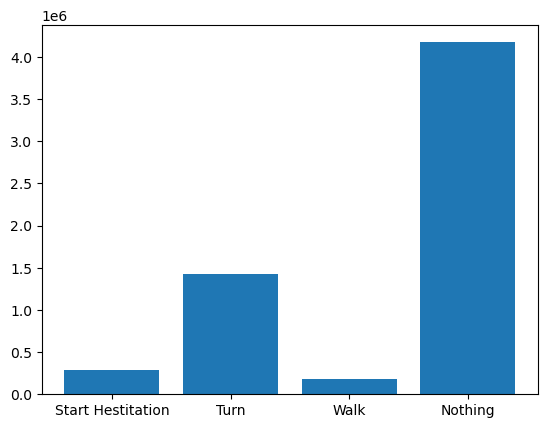

Inputs shape: (703972, 21, 3), targets shape: (703972,)


In [4]:
fog.balance()

In [8]:
from sklearn.utils import shuffle
X, y = shuffle(fog.series_inputs, fog.series_targets)

In [11]:
LSTMcells = [tf.keras.layers.LSTMCell(64) for _ in range(5)]
lstm = tf.keras.layers.StackedRNNCells(LSTMcells)

model = tf.keras.Sequential([
    tf.keras.layers.RNN(lstm),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [12]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
history = model.fit(
    X, y,
    batch_size=128,
    epochs=10,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/10
4400/4400 [==============================] - 398s 89ms/step - loss: 1.0273 - accuracy: 0.5492 - val_loss: 0.9401 - val_accuracy: 0.5994
Epoch 2/10
4400/4400 [==============================] - 384s 87ms/step - loss: 0.9067 - accuracy: 0.6152 - val_loss: 0.8618 - val_accuracy: 0.6369
Epoch 3/10
4400/4400 [==============================] - 386s 88ms/step - loss: 0.8414 - accuracy: 0.6465 - val_loss: 0.8189 - val_accuracy: 0.6572
Epoch 4/10
4400/4400 [==============================] - 387s 88ms/step - loss: 0.7944 - accuracy: 0.6671 - val_loss: 0.7873 - val_accuracy: 0.6705
Epoch 5/10
4400/4400 [==============================] - 386s 88ms/step - loss: 0.7541 - accuracy: 0.6857 - val_loss: 0.7634 - val_accuracy: 0.6822
Epoch 6/10
4400/4400 [==============================] - 388s 88ms/step - loss: 0.7192 - accuracy: 0.7020 - val_loss: 0.7338 - val_accuracy: 0.6942
Epoch 7/10
4400/4400 [==============================] - 389s 88ms/step - loss: 0.6878 - accuracy: 0.7153 - val_loss: 0

In [ ]:
plt.plot([288821, 1422321, 175993, 4171408])

In [ ]:
p = np.asarray([[0, 0, 0], [0, 0, 1], [1, 0, 0]])
np.where(
    (
        (p[:,0] == 0) &
        (p[:,1] == 0) &
        (p[:,2] == 0)
    )
)